<a href="https://colab.research.google.com/github/gijsdepooter/FYP/blob/main/Pulser/PWM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motiviation 

The generation of arbitary waveforms is necessary for an number of application:

1.   **Transmit Array Apodization**: This technique improves diagnostic imaging by reducing pressure around the mainlobe, thus lowering scattering from outrside the intended beam
2.    **Coded Exciation**: Useful for increasing the SNR and frame rate, sends long transmit signals to increase the power without increasing the voltage. The recieved signal is compressed by correlating it with transmit pules (match filtering). Normally, Linear frequency signals (LFM) are chosen over phase modulated signals.

PWM is used in power converters, supported by high speed swithing. The carrier signal is the square wave and the modulating signal is the orignial.






(-1.5, 1.5)

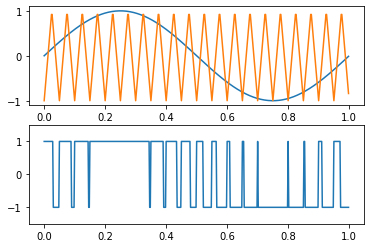

In [10]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

fm =1
fc= 20
duty = 0.5
t = np.linspace(0, 1, 500, endpoint=False)

triangle = signal.sawtooth(2 * np.pi * fc * t, 0.5)

plt.figure()
sig = np.sin(2 * np.pi * fm* t)
pwm = signal.square(2 * np.pi * fc* t, duty=(sig + 1)/2)
plt.subplot(2, 1, 1)
plt.plot(t, sig, t, triangle)
plt.subplot(2, 1, 2)
plt.plot(t, pwm)
plt.ylim(-1.5, 1.5)

#  Transducer as filter

**How is the PWM signal is reconstructed back into the desired signal? **

It is filtered back by the transducer, which acts as a bandpass filter.

two function can be used:

filtfilt is zero-phase filtering, which doesn't shift the signal as it filters. Since the phase is zero at all frequencies, it is also linear-phase. Filtering backwards in time requires you to predict the future, so it can't be used in "online" real-life applications, only for offline processing of recordings of signals.

lfilter is causal forward-in-time filtering only, similar to a real-life electronic filter. It can't be zero-phase. It can be linear-phase (symmetrical FIR), but usually isn't. Usually it adds different amounts of delay at different frequencies.

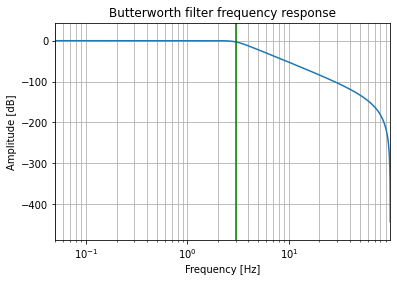

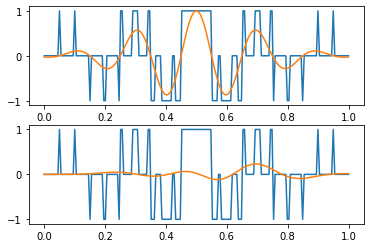

In [13]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, filtfilt
fs = 200

def butter_(cutoff, fs, btype, order=5):
    nyq = 0.5 * fs
    cutoff = np.array(cutoff)
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False) 
    w, h = signal.freqz(b, a,worN=2000)
    plt.figure()
    plt.plot(0.5*fs*w/np.pi, 20 * np.log10(abs(h)))
    plt.xscale('log')
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    if cutoff.size< 2:
      plt.axvline(cutoff, color='green') # cutoff frequency
    else:
      for i in cutoff:
         plt.axvline(i, color='green') # cutoff frequency
         #print(i)
        
    plt.show()
    return b, a
  
def butter_filter(data, cutoff, fs, btype, order=5):
    b, a = butter_(cutoff, fs, btype, order=order)
    y = lfilter(b, a, data)    # IRR
    #y = filtfilt(b, a, data)  # Zero Phase filter
    return y
  
cutoff = 3


out = butter_filter(pwm, cutoff,  fs, 'low', 5)



plt.subplot(2, 1, 1)
plt.plot(t,pwm,t, sig)
plt.subplot(2, 1, 2)
plt.plot(t,pwm,t,out)




# Multilevel Slow switching PWM

In application where the switching  speed - the carrier signal frequency - is two order of magnitude of the modulating signal or less, only one pulse per half cycle is used. 

One can compensate for the relative slow switching by using multilevel PWM. One important thing to note here is the shape of the carrirer of frequency. Ideally you would need a linear mapping between the pulse width and the generated pressure wave. Thus a triangular carrier is not ideal, in the sense it doesnot generated uniform pressure steps at the output of the transducer. 

If you plot the FFT of a square wave, you would actually find the a trigonometric relationship between width and fundmental frequency components. Two thing are to be noted


1.   Harmonics have an influence too, ideally they should be used to design the carrier frequency, but they have been ignored.
2.   An ideal carrier would also consider the transducer bandpass impluse response 

*. Smart ware of compressing the signal could be implemented here. similar to log-compression



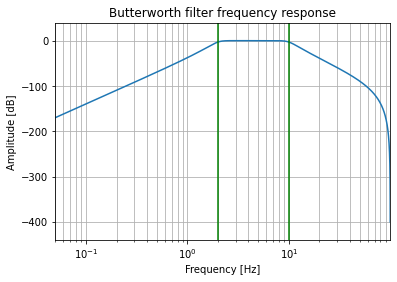

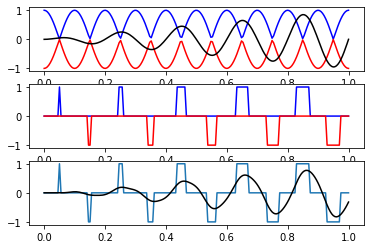

In [4]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt


def carrier(A, L, P, f , t):
  y = A*(np.absolute(np.cos(2*np.pi*f* t + P)) + L)
  return y

fm = 5
fc =1*fm
fs = 200
t = np.linspace(0, 1, fs)

cpos = carrier(1,0,0,fc,t)
cneg = carrier(-1, 0,0,fc,t)
sig = np.sin(2 * np.pi * t*fm) *t
pwmpos = sig >= cpos
pwmneg = -1* (sig <= cneg)
pwm = pwmpos+pwmneg


cutoff = [2,10]
out = butter_filter(pwm, cutoff,  fs, 'bandpass', 5)

plt.subplot(3, 1, 1)
plt.plot(t, cpos,'b',t, cneg,'r',t,sig,'k')
plt.subplot(3, 1, 2)
plt.plot(t, pwmpos,'b',t, pwmneg,'r')
plt.subplot(3, 1, 3)
plt.plot(t,pwm,t,out,'k')

#print("PWM units samples in " + str(Time) + " seconds is: " + str(pwm.size) + " Samples")


## Problems with other waves forms

When Gussian signals for example are used the technique does not work. that is because the the switching speed is low and may not capture that modulating signal

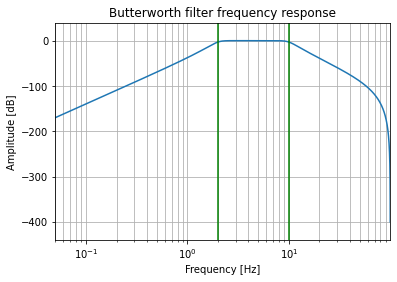

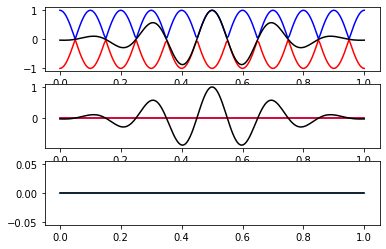

In [5]:
sig, e =signal.gausspulse(t-0.5, fc= 5,  bw=0.4,retenv=True)
pwmpos = sig >= cpos
pwmneg = (sig >= cneg)-1
pwm = pwmpos+pwmneg
cutoff = [2,10]
out = butter_filter(pwm, cutoff,  fs, 'bandpass', 5)
plt.subplot(3, 1, 1)
plt.plot(t, cpos,'b',t, cneg,'r',t,sig,'k')
plt.subplot(3, 1, 2)
plt.plot(t, pwmpos,'b',t, pwmneg,'r',t,sig,'k')
plt.subplot(3, 1, 3)
plt.plot(t,pwm,t,out,'k')

## Solution 2: 90 degrees phase alignment

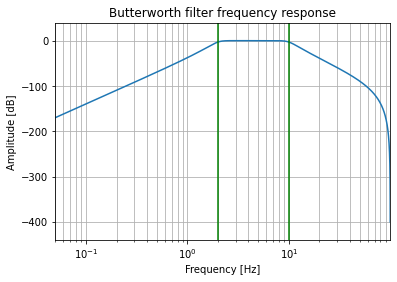

<function matplotlib.pyplot.show(*args, **kw)>

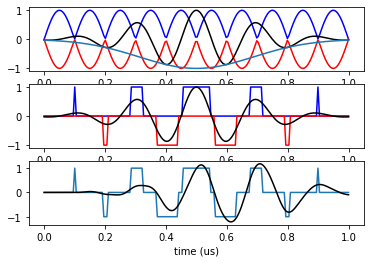

In [33]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt


def carrier(A, L, P, f , t):
  y = A*(np.absolute(np.cos(2*np.pi*f* t + P)) + L)
  return y

fm = 5
fc =1*fm
fs = 200
t = np.linspace(0, 1, fs)

cpos = carrier(1,0,np.pi/2,fc,t)
cneg = carrier(-1, 0,np.pi/2,fc,t)



sig, e =signal.gausspulse(t-0.5, fc= 5,  bw=0.4,retenv=True)


pwmpos = (e >= cpos) * (sig>=0)

pwmneg = -1*((-1*e <= cneg)* (sig<0)) 


#Corrections!
pwmneg[0] = 0
pwmneg[-1] = 0

pwm = pwmpos+pwmneg


cutoff = [2,10]
out = butter_filter(pwm, cutoff,  fs, 'bandpass', 5)

plt.subplot(3, 1, 1)
plt.plot(t, cpos,'b',t, cneg,'r',t,sig,'k',t,-1*e)
plt.subplot(3, 1, 2)
plt.plot(t, pwmpos,'b',t, pwmneg,'r',t,sig,'k')
plt.subplot(3, 1, 3)
plt.plot(t,pwm,t,out,'k')
plt.xlabel("time (us)")
plt.show

In [34]:
import numpy as np

a = np.zeros((2,3))
t = np.linspace(0, 1, 200)

b= t.size

print(b)

l = []
l.append(1)
l.append(2)

print(l[0])

levels =4
swing = 2


scale_arr = np.append(np.full(int(levels/2), swing/levels), np.full(int(levels/2), -1*swing/levels) )

offset_arr= np.append(np.linspace(swing/2-swing/levels, 0, num=int(levels/2)),np.flip(np.linspace(-swing/2+swing/levels, 0, num=int(levels/2))))

print(scale_arr,offset_arr)


200
1
[ 0.5  0.5 -0.5 -0.5] [ 0.5  0.   0.  -0.5]


# Fuction


In [25]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt


def carrier(A, L, P, f , t):
  y = A*(np.absolute(np.cos(2*np.pi*f* t + P))) + L
  return y

def pwm_carrier_generator(swing, levels,fc,t) : #swing is 2 p.p levels is 4
  scale_arr =  np.append(np.full(int(levels/2), swing/levels), np.full(int(levels/2), -1*swing/levels) )
  offset_arr = offset_arr= np.append(np.linspace(swing/2-swing/levels, 0, num=int(levels/2)),np.flip(np.linspace(-swing/2+swing/levels, 0, num=int(levels/2))))
  level_arr = []
  
  for i in range(levels):
    temp = carrier(scale_arr[i],offset_arr[i],np.pi/2,fc,t)
    level_arr.append(temp)
    #plt.plot(t,temp,'k')
  #plt.show()
  level_arr = np.asarray(level_arr)
  return level_arr, scale_arr,offset_arr
  
def pwn_generator(level_arr,scale_arr, offset_arr, sig,e):
  level = scale_arr.size
  output = []
  
  for i in range(level):
    if i<level/2:
      temp = scale_arr[i]* ((e >= level_arr[i,:]) * (sig>=0)) + offset_arr[i]
      output.append(temp)
      #plt.plot(t,temp,'k')
    else:
      temp = scale_arr[i]* ((-1*e <= level_arr[i,:]) * (sig<0)) + offset_arr[i]
      output.append(temp)
      #plt.plot(t,temp,'k')
  output=np.asarray(output)
  output[:,0]  = output[:,1]
  output[:,-1] = output[:,-2]
  #plt.show()y
  return output

def pulse_generator(pwm,scale_arr, offset_arr,levels):
  pulses = []
  for i in range(levels):
    pulses.append((pwm[i,:] - offset_arr[i])/scale_arr[i] + 0)
  return np.transpose(np.asarray(pulses))

In [29]:
def MD1822_cov(V_arr):
  Vpp = V_arr[:,0]
  Vnn = V_arr[:,1]
  pins = np.zeros((Vpp.size,3))
  
  for i in range(Vpp.size):
    if not(Vpp[i] or Vnn[i]): #Zero
      pins[i]= [0,0,1]

    else:
      if(Vpp[i]):     #Vpp
        pins[i]= [1,0,0]

      if(Vnn[i]):     #Vnn 
        pins[i]= [0,1,0]
          
  print("INP INN DMP")
  return np.asarray(pins) 
      
      

  
  
  

In [30]:
l =[]
l = [1,2,3,4]
l = np.zeros((5,200))
print(l.shape[1])

200


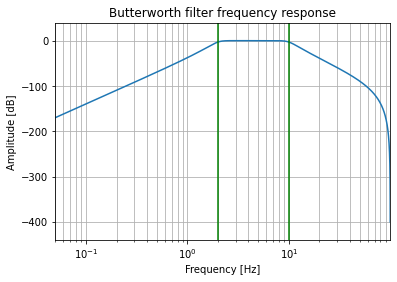

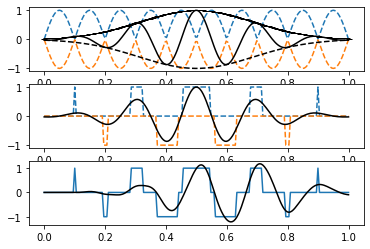

INP INN DMP
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
100
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
010
010
010
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
100
100
100
100
100
100
100
100
001
001
001
001
001
001
001
001
001
010
010
010
010
010
010
010
010
010
010
010
010
010
010
001
001
001
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
001
001
001
010
010
010
010
010
010
010
010
010
010
010
010
010
010
001
001
001
001
001
001
001
001
001
100
100
100
100
100
100
100
100
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
010
010
010
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
100
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001
001


0

In [32]:
def make_mif(arr):
  for i in range(arr.shape[0]):
    for j in  range(arr.shape[1]):
      print(int(arr[i,j]), end ="")
    print("")
  return 0
fm = 5
fc =1*fm
fs = 200
cutoff = [2,10]
t = np.linspace(0, 1, fs)

sig, e =signal.gausspulse(t-0.5, fc= 5,  bw=0.4,retenv=True)

swing = 2
levels = 2 # plus zero


a,b,c = pwm_carrier_generator(swing,levels,fc,t)

d = pwn_generator(a,b,c,sig,e)

pwm = np.sum(d, axis=0)

out = butter_filter(pwm, cutoff,  fs, 'bandpass', 5)



plt.subplot(3, 1, 1)
for i in range(levels):
  plt.plot(t, a[i,:],'--')
plt.plot(t,sig,'k',t,-1*e,'k--',t,e,'k_')  

plt.subplot(3, 1, 2)
for i in range(levels):
  plt.plot(t, d[i,:],'--')
plt.plot(t,sig,'k')
plt.subplot(3, 1, 3)
plt.plot(t,pwm,t,out,'k')

plt.show()

# Write to FPGA
e = pulse_generator(d,b,c,levels)
f = MD1822_cov(e)
#print(f)
make_mif(f)

#print("Vpp1 Vpp2 Vnn2 Vnn1\n", e[:,0].size)